In [ ]:
from    typing      import  Callable

import  numpy               as      np
import  matplotlib.pyplot   as      plt

from    tqdm.notebook       import  tqdm

from    kinetic_distribtutions__numpy   import  *

from    pathlib     import  Path
import  sys
root_dir = Path.cwd().parent.parent
sys.path.append(str(root_dir))
from    numerical           import  utils, distribution
from    numerical.solvers   import  FastSM_Boltzmann_VHS

In [2]:
T1__size, T2__size, T3__size = 1000, 1000, 1000

DIMENSION:  int = 2
RESOLUTION: int = 16
V_MAX:      float = 3.0/utils.LAMBDA
DELTA_V:    float = (2*V_MAX) / RESOLUTION

v_grid = utils.velocity_grid(DIMENSION, RESOLUTION, V_MAX)

FFT_AXES:   tuple[int] = tuple(range(-(1+DIMENSION), -1))
FFT_NORM:   str  = 'forward'

VHS_COEFF = 1.0     # 1 / utils.area_of_unit_sphere(DIMENSION)


sample_q: Callable[[int], tuple[np.ndarray]] = lambda batch_size: sample_quantities(DIMENSION, batch_size)

# Saved information
dataset_info: dict[str, object] = {
    'dimension':    DIMENSION,
    'resolution':   RESOLUTION,
    'v_max':        V_MAX,
    'vhs_coeff':    VHS_COEFF,
    'equation':     'Boltzmann',
}


# Plot configuration
PLOT__NUM_INSTANCES:    int    = 4
PLOT__FIGSIZE:          tuple[float]    = (4.2*PLOT__NUM_INSTANCES, 8.0)
PLOT__EXTENT:           tuple[float]    = (-V_MAX, V_MAX, -V_MAX, V_MAX)

In [3]:
solver_maxwellian = FastSM_Boltzmann_VHS(
    dim         = DIMENSION,
    v_num_grid  = RESOLUTION,
    v_max       = V_MAX,
    vhs_alpha   = 0.0,
    vhs_coeff   = VHS_COEFF,
    
    quad_order_uniform  = 25,
    quad_order_legendre = 50,
    quad_order_lebedev  = 7,
)
solver_maxwellian.precompute()

solver_hard_sphere = FastSM_Boltzmann_VHS(
    dim         = DIMENSION,
    v_num_grid  = RESOLUTION,
    v_max       = V_MAX,
    vhs_alpha   = 1.0,
    vhs_coeff   = VHS_COEFF,
    
    quad_order_uniform  = 25,
    quad_order_legendre = 50,
    quad_order_lebedev  = 7,
)
solver_hard_sphere.precompute()

Type 1. Maxwellian distribution

In [4]:
# T1__data: np.ndarray = distribution.maxwellian_homogeneous(v_grid, *sample_q(T1__size))
T1__data: np.ndarray = distribution.maxwellian_homogeneous(v_grid, *sample_quantities(DIMENSION, T1__size, 0.0, 0.0))
T1__data = normalize_density(T1__data, DELTA_V)
print(f"The shape of the data >>> {T1__data.shape}")

The shape of the data >>> (1000, 1, 1, 16, 16, 1)


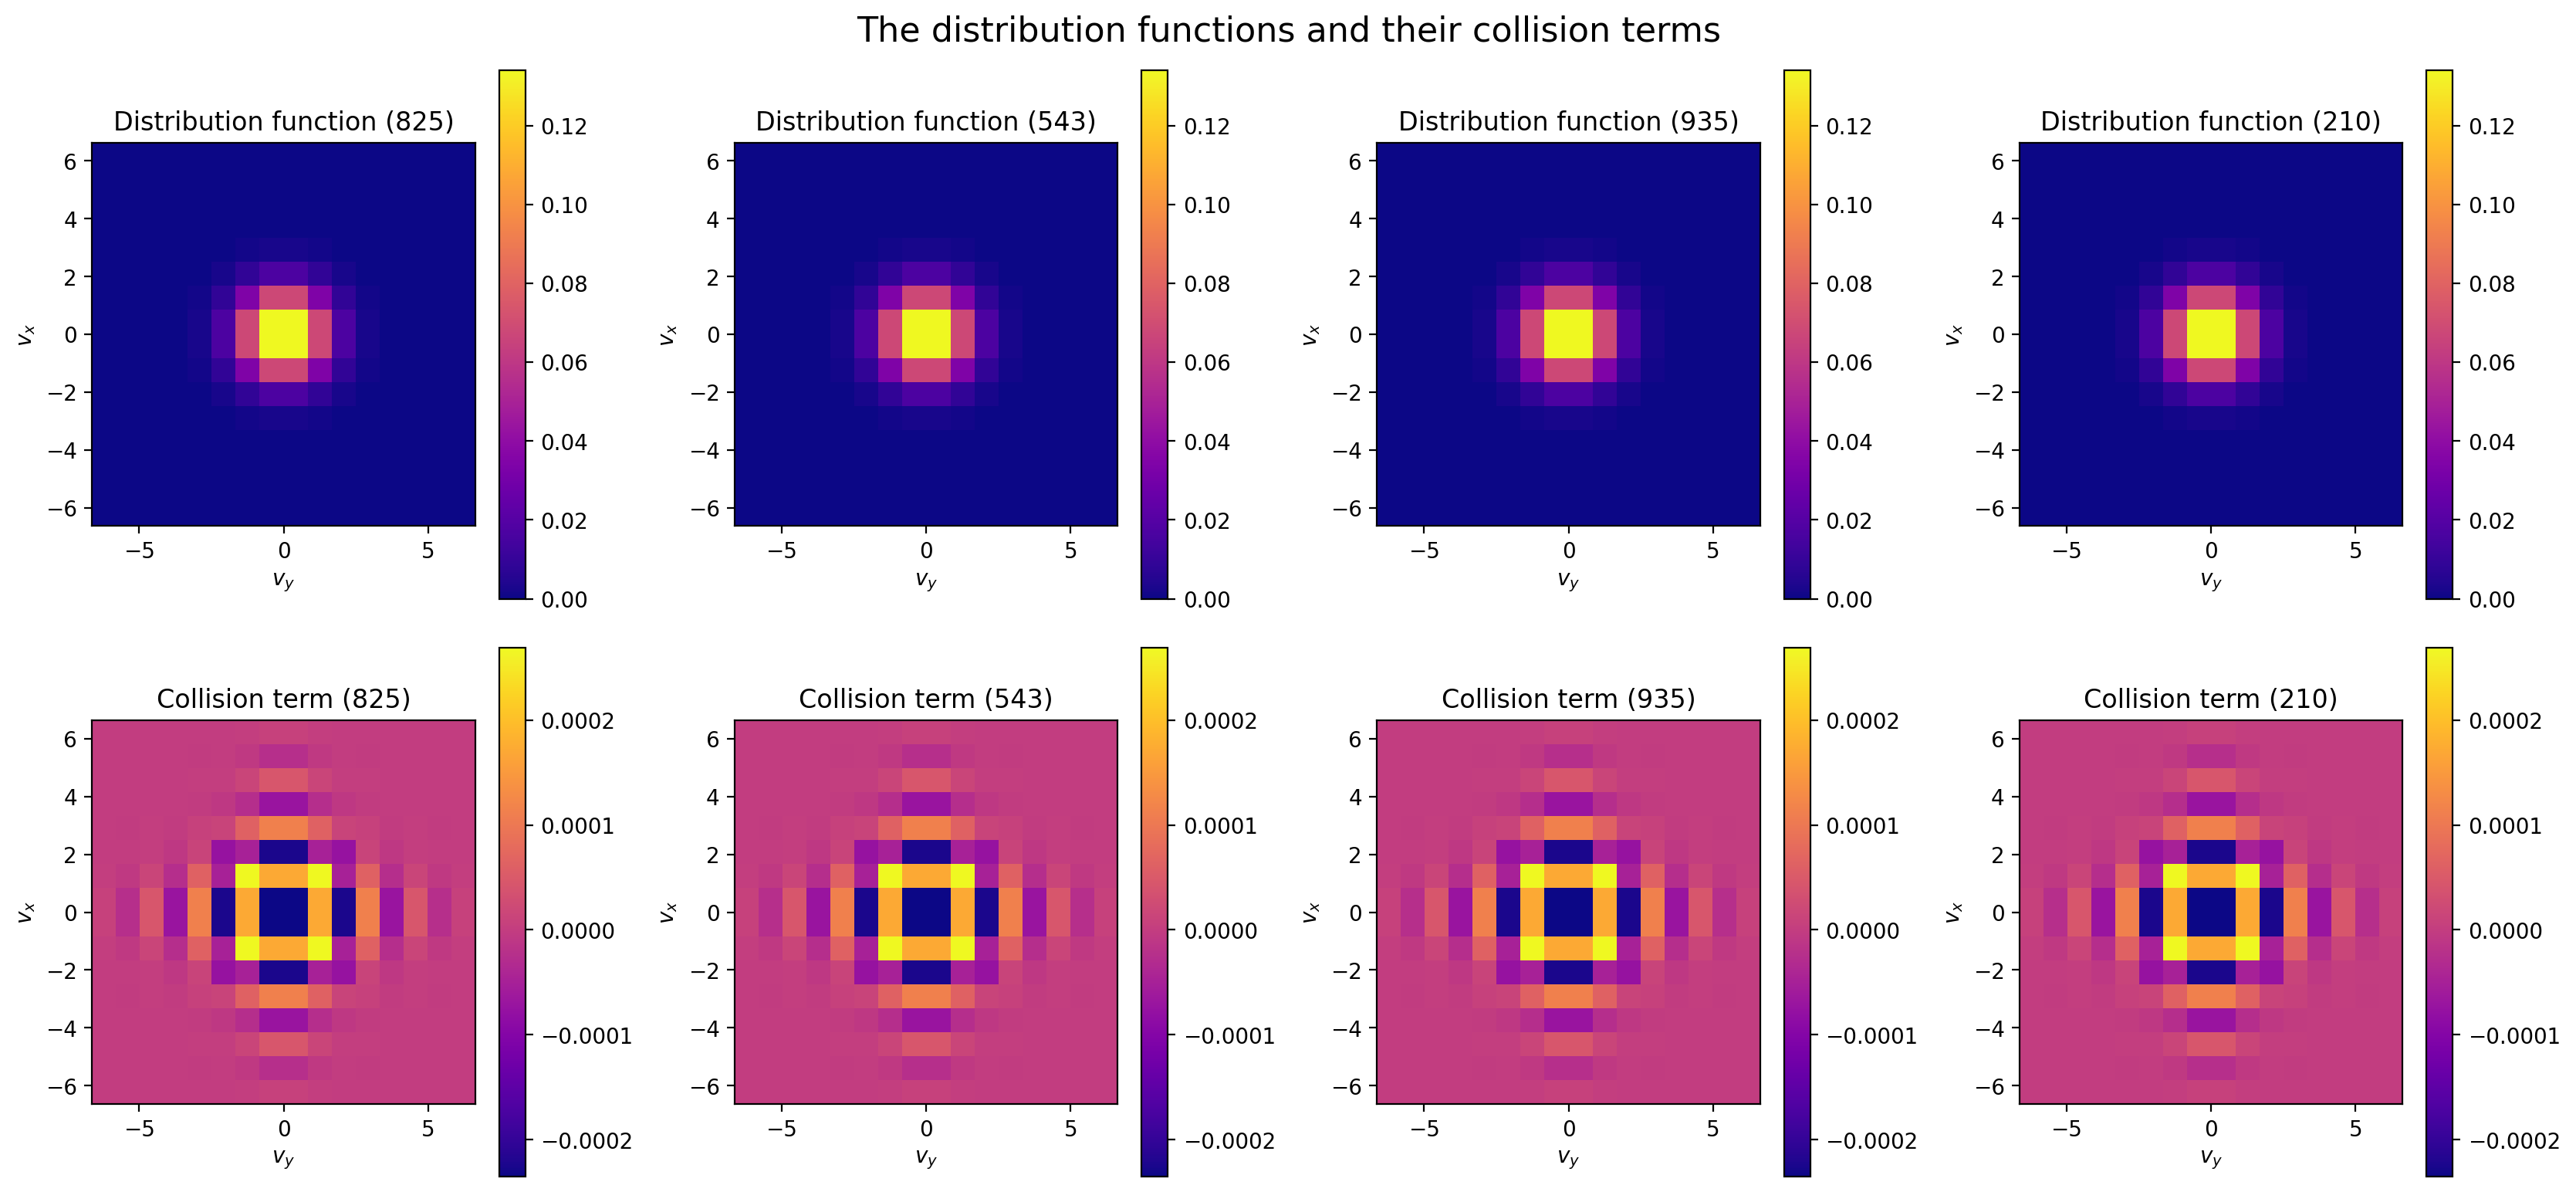

In [5]:
fig, axes = plt.subplots(2, PLOT__NUM_INSTANCES, figsize=PLOT__FIGSIZE, dpi=200)
fig.suptitle("The distribution functions and their collision terms", fontsize=16)
rand_indices = np.random.randint(0, T1__size, size=(PLOT__NUM_INSTANCES,))
__T1_sample = T1__data[rand_indices]
__T1_collision: np.ndarray
__T1_collision = solver_maxwellian.compute_collision_fft(None, np.fft.fftn(__T1_sample, axes=FFT_AXES, norm=FFT_NORM))
__T1_collision = np.fft.ifftn(__T1_collision, axes=FFT_AXES, norm=FFT_NORM).real

for idx_ax, cnt in enumerate(range(PLOT__NUM_INSTANCES)):
    # Row 0: Distribution function
    axes[0, idx_ax].set_title(f"Distribution function ({int(rand_indices[cnt])})")
    fig.colorbar(
        axes[0, idx_ax].imshow(
            __T1_sample[cnt].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=PLOT__EXTENT,
            cmap='plasma',
        )
    )
    axes[0, idx_ax].set_xlabel(r"$v_y$")
    axes[0, idx_ax].set_ylabel(r"$v_x$")
    # Row 1: Collision term
    fig.colorbar(
        axes[1, idx_ax].imshow(
            __T1_collision[cnt].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=PLOT__EXTENT,
            cmap='plasma',
        )
    )
    axes[1, idx_ax].set_title(f"Collision term ({int(rand_indices[cnt])})")
    axes[1, idx_ax].set_xlabel(r"$v_y$")
    axes[1, idx_ax].set_ylabel(r"$v_x$")
plt.tight_layout()
plt.show()

del(__T1_sample, __T1_collision)

Type 2. Sum of two Maxwellian distributions

In [6]:
T2__data: np.ndarray = \
    0.5 * (
        distribution.maxwellian_homogeneous(v_grid, *sample_q(T2__size))
        +
        distribution.maxwellian_homogeneous(v_grid, *sample_q(T2__size))
    )
T2__data = normalize_density(T2__data, DELTA_V)

print(f"The shape of the data >>> {T2__data.shape}")

The shape of the data >>> (1000, 1, 1, 16, 16, 1)


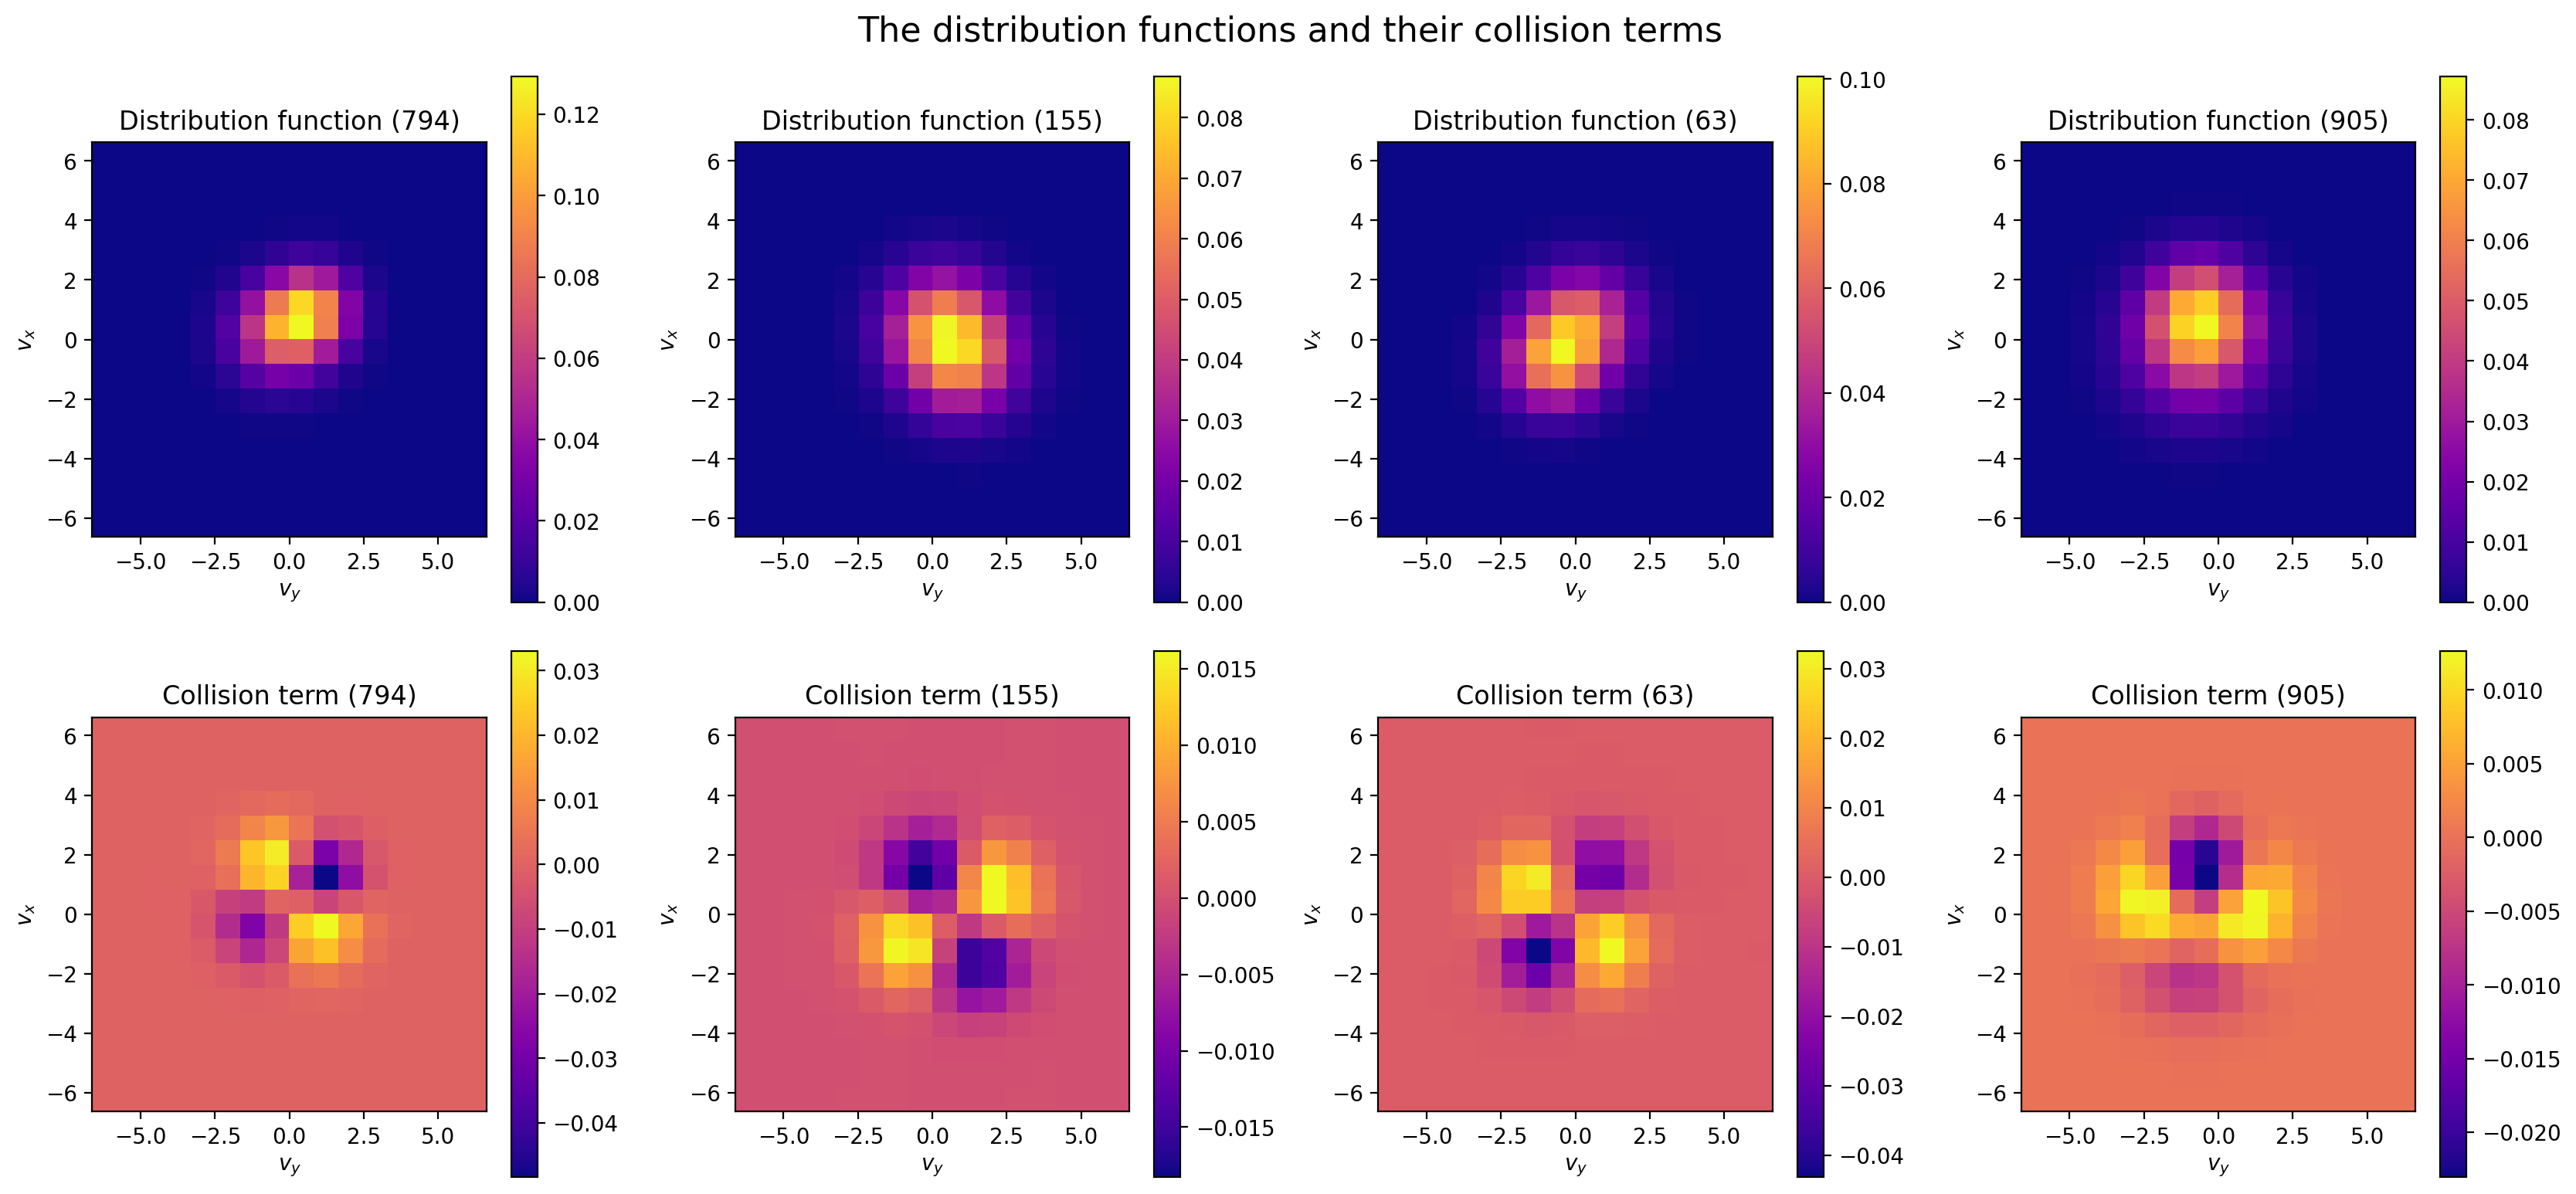

In [7]:
fig, axes = plt.subplots(2, PLOT__NUM_INSTANCES, figsize=PLOT__FIGSIZE, dpi=200)
fig.suptitle("The distribution functions and their collision terms", fontsize=16)
rand_indices = np.random.randint(0, T2__size, size=(PLOT__NUM_INSTANCES,))
__T2_sample = T2__data[rand_indices]
__T2_collision: np.ndarray
__T2_collision = solver_maxwellian.compute_collision_fft(None, np.fft.fftn(__T2_sample, axes=FFT_AXES, norm=FFT_NORM))
__T2_collision = np.fft.ifftn(__T2_collision, axes=FFT_AXES, norm=FFT_NORM).real

for idx_ax, cnt in enumerate(range(PLOT__NUM_INSTANCES)):
    # Row 0: Distribution function
    axes[0, idx_ax].set_title(f"Distribution function ({int(rand_indices[cnt])})")
    fig.colorbar(
        axes[0, idx_ax].imshow(
            __T2_sample[cnt].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=PLOT__EXTENT,
            cmap='plasma',
        )
    )
    axes[0, idx_ax].set_xlabel(r"$v_y$")
    axes[0, idx_ax].set_ylabel(r"$v_x$")
    # Row 1: Collision term
    fig.colorbar(
        axes[1, idx_ax].imshow(
            __T2_collision[cnt].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=PLOT__EXTENT,
            cmap='plasma',
        )
    )
    axes[1, idx_ax].set_title(f"Collision term ({int(rand_indices[cnt])})")
    axes[1, idx_ax].set_xlabel(r"$v_y$")
    axes[1, idx_ax].set_ylabel(r"$v_x$")
plt.tight_layout()
plt.show()

del(__T2_sample, __T2_collision)

Type 3. Perturbed Maxwellian distributions

In [8]:
coeffs = sample_noise_quadratic(DIMENSION, V_MAX, T3__size)
quad = compute_quadratic_polynomial(v_grid, coeffs)
quad = quad.reshape(T3__size, *utils.ones(DIMENSION), *utils.repeat(RESOLUTION, DIMENSION), 1)

T3__data: np.ndarray = \
    distribution.maxwellian_homogeneous(v_grid, *sample_q(T3__size)) * \
    (1 + quad)

T3__data = normalize_density(T3__data, DELTA_V)
print(f"The shape of the data >>> {T3__data.shape}")

(1000, 1)
(1000, 2)
(1000, 4)
The shape of the data >>> (1000, 1, 1, 16, 16, 1)


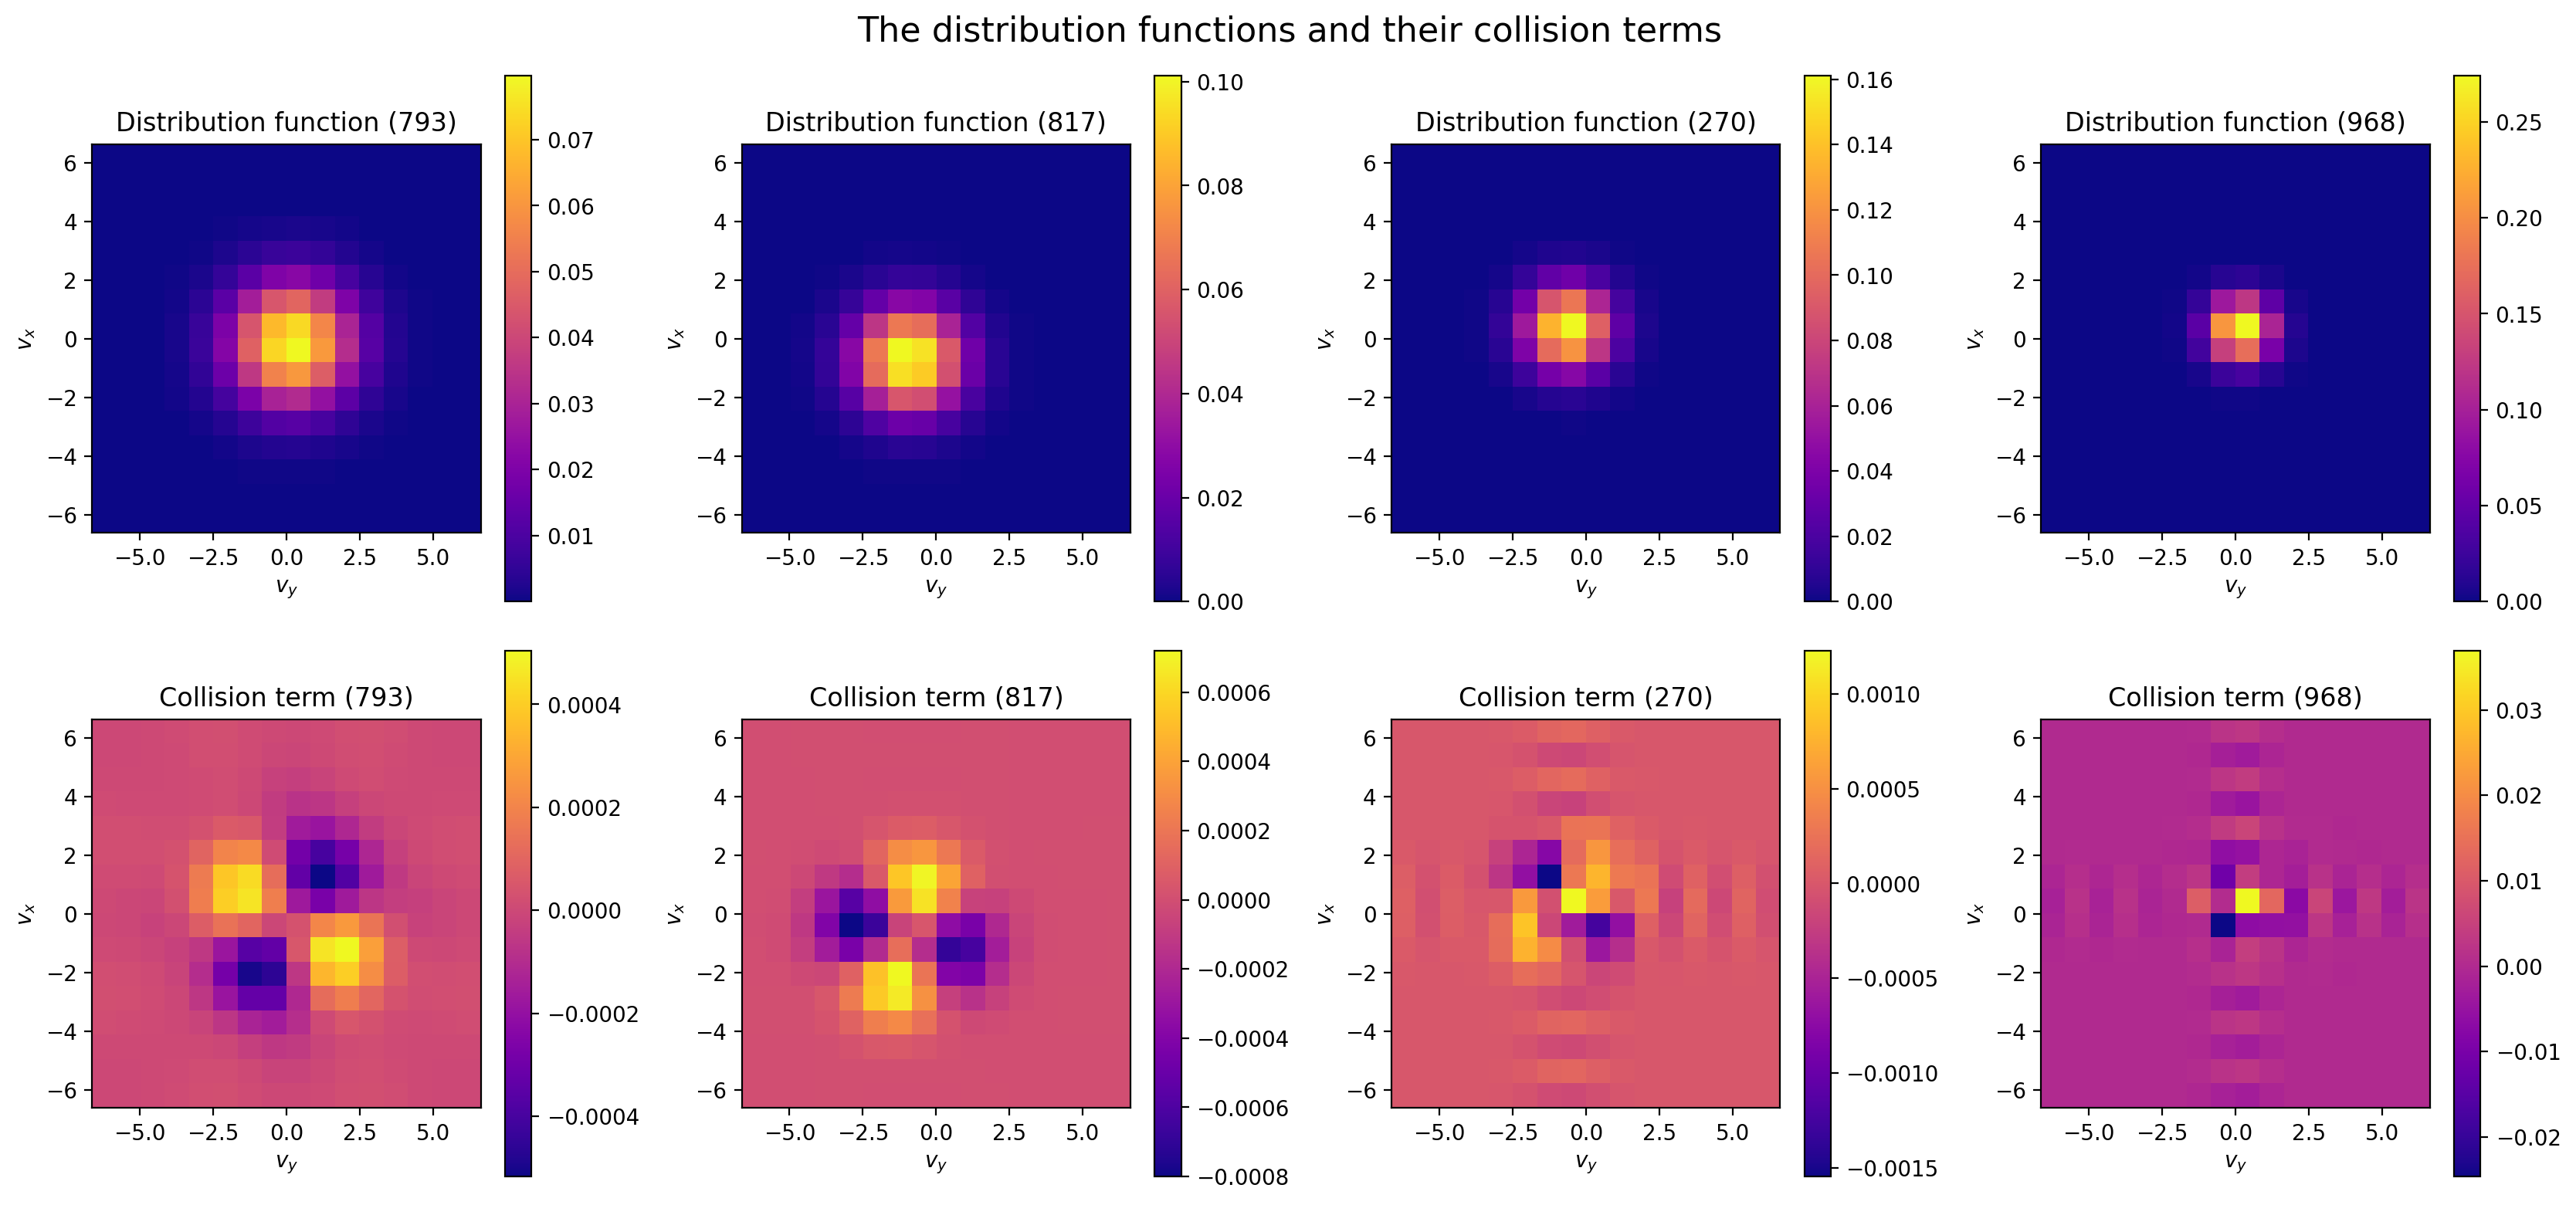

In [9]:
fig, axes = plt.subplots(2, PLOT__NUM_INSTANCES, figsize=PLOT__FIGSIZE, dpi=200)
fig.suptitle("The distribution functions and their collision terms", fontsize=16)
rand_indices = np.random.randint(0, T3__size, size=(PLOT__NUM_INSTANCES,))
__T3_sample = T3__data[rand_indices]
__T3_collision: np.ndarray
__T3_collision = solver_maxwellian.compute_collision_fft(None, np.fft.fftn(__T3_sample, axes=FFT_AXES, norm=FFT_NORM))
__T3_collision = np.fft.ifftn(__T3_collision, axes=FFT_AXES, norm=FFT_NORM).real

for idx_ax, cnt in enumerate(range(PLOT__NUM_INSTANCES)):
    # Row 0: Distribution function
    axes[0, idx_ax].set_title(f"Distribution function ({int(rand_indices[cnt])})")
    fig.colorbar(
        axes[0, idx_ax].imshow(
            __T3_sample[cnt].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=PLOT__EXTENT,
            cmap='plasma',
        )
    )
    axes[0, idx_ax].set_xlabel(r"$v_y$")
    axes[0, idx_ax].set_ylabel(r"$v_x$")
    # Row 1: Collision term
    fig.colorbar(
        axes[1, idx_ax].imshow(
            __T3_collision[cnt].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=PLOT__EXTENT,
            cmap='plasma',
        )
    )
    axes[1, idx_ax].set_title(f"Collision term ({int(rand_indices[cnt])})")
    axes[1, idx_ax].set_xlabel(r"$v_y$")
    axes[1, idx_ax].set_ylabel(r"$v_x$")
plt.tight_layout()
plt.show()

del(__T3_sample, __T3_collision)

Merge the data

In [11]:
dataset: np.ndarray = np.concatenate((T1__data, T3__data, T3__data), axis=0)
print(f"The shape of the dataset >>> {dataset.shape}")

The shape of the dataset >>> (3000, 1, 1, 16, 16, 1)


In [ ]:
# Compute the collision terms
split_size = 10
assert dataset.shape[0] % split_size == 0

Q_fft_alpha_0_gain: list[np.ndarray]  = []
Q_fft_alpha_0_loss: list[np.ndarray]  = []
Q_fft_alpha_1_gain: list[np.ndarray]  = []
Q_fft_alpha_1_loss: list[np.ndarray]  = []

for _dataset in tqdm(np.split(dataset, split_size, axes=0)):
    _dataset_fft = np.fft.fftn(_dataset, axes=FFT_AXES, norm=FFT_NORM)

    # 1. Maxwellian molecules
    _Q_fft_alpha_0_gain = solver_maxwellian.compute_collision_gain_fft(None, _dataset_fft)
    _Q_fft_alpha_0_loss = solver_maxwellian.compute_collision_loss_fft(None, _dataset_fft)
    Q_fft_alpha_0_gain.append(_Q_fft_alpha_0_gain)
    Q_fft_alpha_0_loss.append(_Q_fft_alpha_0_loss)

    # 2. Hard spheres
    _Q_fft_alpha_1_gain = solver_hard_sphere.compute_collision_gain_fft(None, _dataset_fft)
    _Q_fft_alpha_1_loss = solver_hard_sphere.compute_collision_loss_fft(None, _dataset_fft)
    Q_fft_alpha_1_gain.append(_Q_fft_alpha_1_gain)
    Q_fft_alpha_1_loss.append(_Q_fft_alpha_1_loss)

Q_fft_alpha_0_gain  = np.concatenate(Q_fft_alpha_0_gain, axis=0)
Q_fft_alpha_0_loss  = np.concatenate(Q_fft_alpha_0_loss, axis=0)
Q_fft_alpha_1_gain  = np.concatenate(Q_fft_alpha_1_gain, axis=0)
Q_fft_alpha_1_loss  = np.concatenate(Q_fft_alpha_1_loss, axis=0)

In [ ]:
np.savez(
    root_dir / f"datasets/float64/Boltzmann__alpha_0__res_{RESOLUTION}.npz",
    data        = dataset,
    gain_fft    = Q_fft_alpha_0_gain,
    loss_fft    = Q_fft_alpha_0_loss,
    **dataset_info,
    vhs_alpha   = 0.0,
)
np.savez(
    root_dir / f"datasets/float64/Boltzmann__alpha_0__res_{RESOLUTION}.npz",
    data        = dataset,
    gain_fft    = Q_fft_alpha_1_gain,
    loss_fft    = Q_fft_alpha_1_loss,
    **dataset_info,
    vhs_alpha   = 1.0,
)
print(f"Done")

End of file